In [12]:
import yfinance as yf
import pandas as pd
import numpy as np

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.over_sampling import SMOTE

from label import TripleBarrier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
msft = yf.Ticker("EURUSD=X")
# get historical market data
hist = msft.history(period="max", start="2001-01-01", end="2020-07-17")

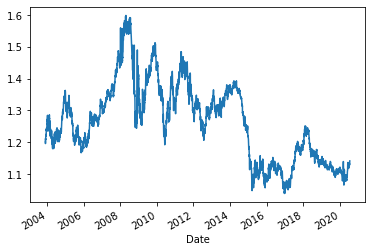

In [32]:
hist.Open.plot()

In this notebook, we explore the usage of triple-barrier method / meta-labelling to identify price signals in the market using an ML approach. <br><br> The triple-barrier is a simple labelling technique consisting of three barriers: an upper barrier, a lower barrier and a vertical barrier. <br><br>  1. Upper Barrier: Threshold an observation return needs to reach to consider a BUY (1) <br> 2. Lower Barrier: Treshold an observed return needs to reach to consider a SELL (-1) <br> 3. Vertical Barrier: Amount of time the observation has to reach without hitting the upper or lower barrier (0) <br>
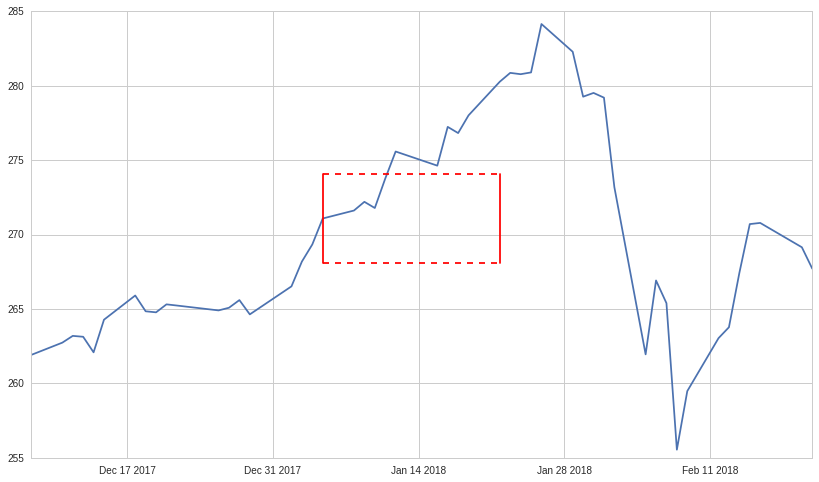

Meta Learning is where we make use of a secondary ML model to learn how to use the result of the first ML model. 
<br>
<br>
In this instance, it is termed meta labelling as we train the model to decide if we should trade or pass on the initial predict of [-1, 0, 1]. We do this by labelling the predicted outputs with the actual labels of the primary model as use the new label as prediction goal for the second model. 
<br>
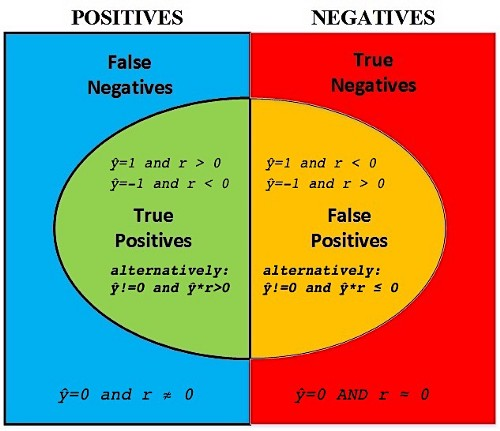

In [3]:
data = hist.copy()
hist.dropna(axis=0, how='any', inplace=True)

In [6]:
factor = [2, 2] # Scale of barrier height
labels = TripleBarrier(hist['Close'], vol_span=50, barrier_horizon=5, factors=factor, label=0).labels

In [10]:
# Load additional features
data['log_ret'] = np.log(data['Close']).diff()
data['mom1'] = data['Close'].pct_change(periods=1)
data['mom2'] = data['Close'].pct_change(periods=2)
data['mom3'] = data['Close'].pct_change(periods=3)
data['mom4'] = data['Close'].pct_change(periods=4)
data['mom5'] = data['Close'].pct_change(periods=5)
data['volatility'] = data['Close'].rolling(window=7, min_periods=7, center=False).std()
data['autocorr_1'] = data['Close'].rolling(window=7, min_periods=7, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
data['autocorr_2'] = data['Close'].rolling(window=7, min_periods=7, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
data['autocorr_3'] = data['Close'].rolling(window=7, min_periods=7, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
data['autocorr_4'] = data['Close'].rolling(window=7, min_periods=7, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
data['autocorr_5'] = data['Close'].rolling(window=7, min_periods=7, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)
data['log_t1'] = data['log_ret'].shift(1)
data['log_t1'] = data['log_ret'].shift(2)
data['log_t1'] = data['log_ret'].shift(3)
data['log_t1'] = data['log_ret'].shift(4)
data['log_t1'] = data['log_ret'].shift(5)
data['fast_mavg'] = data['Close'].rolling(window=7, min_periods=7, center=False).mean()
data['slow_mavg'] = data['Close'].rolling(window=15, min_periods=15, center=False).mean()

In [11]:
# Split into X and Y 
X = data.loc[labels.index, :]
X = X.dropna()
y_labels = labels.loc[X.index, :]
y = y_labels['bin']

In [13]:
# Use VIF to identify and drop highly correlated features 
k = X.copy()
k = k.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

def calc_vif(k, threshold=5):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(k.values, i) for i in range(k.shape[1])]
    vif["features"] = k.columns
    vif = vif.replace([np.inf, -np.inf], np.nan)
    vif = vif.dropna()
    vif["VIF Factor"] = vif[vif["VIF Factor"] < threshold]
    vif = vif.dropna()
    print(vif)
    return vif.features.values.tolist()

X = k[calc_vif(k)]

   VIF Factor    features
13    4.40251  volatility
14    2.62052  autocorr_1
15    1.80057  autocorr_2
16    1.42018  autocorr_3
17    1.10105  autocorr_4
18    1.00751  autocorr_5
19    2.99155      log_t1


D:\Anaconda\envs\financial\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


In [16]:
# Split into Train Test and leave the last year for OOS 
X_training_val = X['2001-01-01' : '2019-01-01']
Y_training_val = y['2001-01-01' : '2019-01-01']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_val, Y_training_val, test_size=0.2, shuffle=False)
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

 0    2391
-1     368
 1     311
Name: bin, dtype: int64

In [17]:
# Lets Resample them 

majority = train_df[train_df['bin']==0]
mid = train_df[train_df['bin']==-1]
minority = train_df[train_df['bin']==1]

sell = resample(minority,
               replace=True,
               n_samples=majority.shape[0],
               random_state=144)

buy = resample(mid,
              replace=True,
              n_samples=majority.shape[0],
              random_state=144)

train_df = pd.concat([majority, buy, sell])
train_df = shuffle(train_df, random_state=144)
train_df['bin'].value_counts()

-1    2391
 1    2391
 0    2391
Name: bin, dtype: int64

In [18]:
# Create training data
y_train = train_df['bin']
X_train = train_df.loc[:, train_df.columns != 'bin']

In [19]:
parameters = {'max_depth':[2, 3, 4, 5, 6, 7],
             'n_estimators':[1, 10, 25, 50, 100, 256, 512],
             'random_state':[144]}

def grid_search(X, y):
    rf = RandomForestClassifier(criterion='entropy')
    clf = GridSearchCV(rf, parameters, cv=4, scoring='f1_macro', n_jobs=-1)
    clf.fit(X, y)
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

n_estimators, depth = grid_search(X_train, y_train)

# Primary Model 

Get the predictions of the first model [-1, 0, 1]

In [20]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimators, criterion='entropy', random_state=144)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=512,
                       random_state=144)

In [22]:
# Metrics
y_pred = rf.predict(X_validate)
print(classification_report(y_validate, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

              precision    recall  f1-score   support

          -1       0.10      0.52      0.16        67
           0       0.85      0.30      0.45       610
           1       0.11      0.22      0.14        91

    accuracy                           0.31       768
   macro avg       0.35      0.35      0.25       768
weighted avg       0.70      0.31      0.39       768

Confusion Matrix
[[ 35  13  19]
 [276 185 149]
 [ 52  19  20]]
Accuracy
0.3125


In [24]:
def binary_label(y_pred, y_test):
    bin_label = np.zeros_like(y_pred)
    for i in range(y_pred.shape[0]):
        if y_pred[i] != 0 and y_pred[i]*y_test[i] > 0:
            bin_label[i] = 1 
    return bin_label

print(classification_report(binary_label(y_pred, y_validate), y_pred != 0))
print("Confusion Matrix")
print(confusion_matrix(binary_label(y_pred, y_validate), y_pred != 0))
print("Accuracy")
print(accuracy_score(binary_label(y_pred, y_validate), y_pred != 0))

              precision    recall  f1-score   support

           0       1.00      0.30      0.47       713
           1       0.10      1.00      0.18        55

    accuracy                           0.35       768
   macro avg       0.55      0.65      0.32       768
weighted avg       0.94      0.35      0.45       768

Confusion Matrix
[[217 496]
 [  0  55]]
Accuracy
0.3541666666666667


# Secondary Model

In [26]:
y_train_pred = rf.predict(X_train)
X_train_meta = np.hstack([y_train_pred[:, None], X_train])
X_test_meta = np.hstack([y_pred[:, None], X_validate])
y_train_meta = binary_label(y_train_pred, y_train)
sm = SMOTE()
X_train_meta_res, y_train_meta_res = sm.fit_sample(X_train_meta, y_train_meta)
n_estimators, depth = grid_search(X_train_meta_res, y_train_meta_res)
rf2 = RandomForestClassifier(max_depth=depth, n_estimators=n_estimators, criterion='entropy', random_state=144)
model_s = rf2.fit(X_train_meta_res, y_train_meta_res)

In [27]:
y_pred_meta = model_s.predict(X_test_meta)

print("Confusion Matrix")
print(confusion_matrix(binary_label(y_pred, y_validate), (y_pred * y_pred_meta) != 0))
print("Accuracy")
print(accuracy_score(binary_label(y_pred, y_validate), (y_pred * y_pred_meta) != 0))

Confusion Matrix
[[284 429]
 [ 10  45]]
Accuracy
0.4283854166666667


# OOS Sample Results

In [28]:
X_oos = X['2019-01-01':'2020-01-01']
y_oos = y['2019-01-01':'2020-01-01']

In [29]:
y_pred = rf.predict(X_oos)
X_test_meta = np.hstack([y_pred[:,None], X_oos])
y_pred_meta = model_s.predict(X_test_meta)
print(classification_report(binary_label(y_pred, y_validate), (y_pred*y_pred_meta) != 0))
print("Confusion Matrix")
print(confusion_matrix(binary_label(y_pred, y_validate), (y_pred*y_pred_meta) != 0))
print("Accuracy")
print(accuracy_score(binary_label(y_pred, y_validate), (y_pred*y_pred_meta) != 0))

              precision    recall  f1-score   support

           0       0.99      0.31      0.47       238
           1       0.11      0.95      0.20        21

    accuracy                           0.36       259
   macro avg       0.55      0.63      0.33       259
weighted avg       0.92      0.36      0.45       259

Confusion Matrix
[[ 74 164]
 [  1  20]]
Accuracy
0.36293436293436293


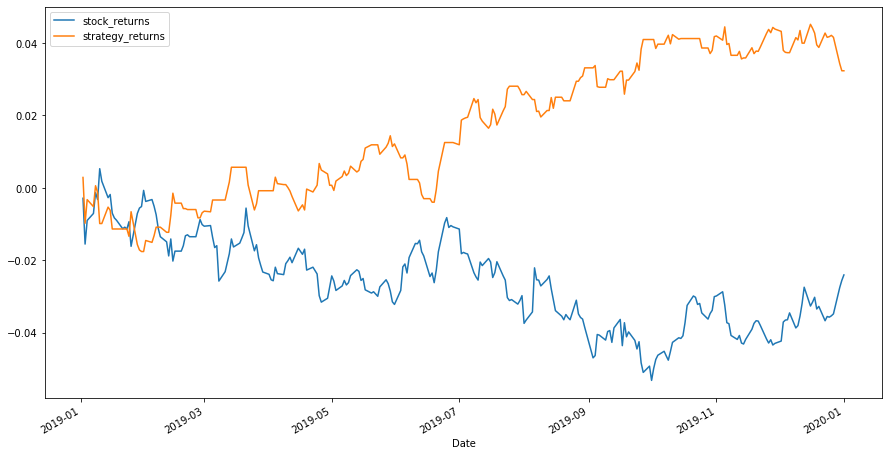

In [31]:
predictions = y_pred * y_pred_meta

# Compare against market returns
price = hist['Open']
ret = price[X_oos.index]
d = pd.DataFrame()
d['stock_returns'] = np.log(ret) - np.log(ret.shift(1))
d['strategy_returns'] = d['stock_returns'] * predictions
d[['stock_returns', 'strategy_returns']].cumsum().plot(figsize=(15,8))

Conclusion : Even though we got lucky and the strategy seem to perform better than the benchmark, it is important to note that our accuracy and ability to identified trading scenarios is flawed in the model metrics, more exploration into parameters settings could yield better results, however this notebook is a good foundation for an ML approach to predicting price signals. 

P.S. This is a good example of how a bad strategy can sometimes luck out and perform super well against the benchmark, if we just blindly follow the this curve as our result, we would assume that this strategy is amazing 